<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210804_PCA_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기
* 결측치처리 완료
* 상관계수 0.9 이상인 컬럼 삭제 완료
* VIF 값이 30 이하가 될 때까지 컬럼 삭제 완료
    * 삭제 방법 : VIF 연산 > 가장 높은 VIF값이 30 이상이면 그 컬럼 삭제 > VIF 연산 반복
* 할 일
    * right 컬럼 지우기
    * 스케일링
    * PCA 수행
    * 나온 2개 값으로 산포도 그려보기
    * 설명변수 비율 뽑아서 가장 큰 피처들 2개로 산포도 그려서 비교해볼까?

In [3]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
origin_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')
origin_data = origin_data.set_index('dat...date.name.', drop=True)

print(len(origin_data.columns))
origin_data.columns
origin_data.head()
# 레이블 : 'L.RD', 'L.Vac', 'R.RD', 'R.Vac'

840


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

In [4]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
fact_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/0804 VIF 수행후 컬럼삭제_Right 컬럼 포함됨/fact_data_vif.csv')
fact_data = fact_data.set_index('dat...date.name.', drop=True)

print(len(fact_data.columns))
fact_data.columns

179


Index(['X1WOS45106_PV', 'X1WOS45107_PV', 'X1WOS45109_PV',
       'DCS_Offset_RPM_M11.1WOS45111_PV', 'DCS_Offset_RPM_M15.1WOS45115_PV',
       'DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV', 'N2.TO.EA1313A.1FI33503A_PV',
       'ROOF.HEATING.Zone.1.1JIC31101.PV', 'ROOF.HEATING.Zone.2.1JIC31102.PV',
       'ROOF.HEATING.Zone.3.1JIC31103.PV',
       ...
       'S_C1_C2_L_L', 'S_C2_C3_U_R', 'S_C3_C4_U_L', '투입.LEFT.',
       'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.', 'ROLLDOWN.폐기.RIGHT.',
       '진공패드.폐기.RIGHT.', 'ROLLDOWN.진공패드.폐기율..LEFT.',
       'ROLLDOWN.진공패드.폐기율..RIGHT.'],
      dtype='object', length=179)

## PCA 수행하기 전 데이터 전처리

### Right 공정 컬럼 제외

In [5]:
# 컬럼명 분류 딕셔너리 파일 불러오기
import pickle

# load data
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/dict_left_right.pickle', 'rb') as fr:
    dict_l_r = pickle.load(fr)

In [6]:
# Right 공정 컬럼명만 리스트로 만들기
print(dict_l_r.keys())
print(type(dict_l_r['Right']))
col_right = dict_l_r['Right']

dict_keys(['Left', 'Right', 'Center'])
<class 'list'>


In [7]:
# 전체 컬럼에서 right 공정 컬럼을 제외한 컬럼명 리스트 만들기

col_use = []

# 데이터의 전체 컬럼에 대해서
for col in fact_data.columns:
    # 만약 컬럼이 right 생산공정에 포함되지 않는다면
    if col not in col_right:
        # 그 컬럼을 col_use 리스트에 추가할 것
        col_use.append(col)

print(len(col_use))
# 179 -> 150개로 줄어들음

150


In [8]:
# 데이터프레임 저장
fact_data_150 = fact_data[col_use]
# 확인
fact_data_150.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 150 entries, X1WOS45106_PV to ROLLDOWN.진공패드.폐기율..LEFT.
dtypes: float64(150)
memory usage: 9.4+ MB


In [9]:
# 레이블 컬럼이 쓸 컬럼목록에 있는지 확인
col_label = ['L.RD', 'L.Vac', 'R.RD', 'R.Vac']
for col in col_label:
    if col in col_use:
        print("확인", col)
# 없음

### 컬럼 확인

In [10]:
# 모든 행에 대해 같은 값을 갖는 컬럼이 있는지 확인
all_value_same_col=[]
for i in range(len(fact_data_150.columns)):
    if min(fact_data_150.iloc[:, i]) == max(fact_data_150.iloc[:, i]):
        print(i)
        all_value_same_col.append(i)
if len(all_value_same_col)==0:
    print("모든 행에 대해 같은 값을 갖는 컬럼은 없습니다")

모든 행에 대해 같은 값을 갖는 컬럼은 없습니다


In [11]:
fact_data_150.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L,투입.LEFT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.진공패드.폐기율..LEFT.
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000096,0.000519,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,-0.000196,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,0.000470,...,-0.000104,0.001108,0.001127,0.000704,0.000652,-0.000388,0.001061,-0.000284,0.000130,0.000162,0.000249,0.000042,-0.000222,0.000974,0.001102,0.001712,-0.000169,-0.000120,-0.000605,0.000553,0.000667,0.000614,-0.000795,0.000196,0.001651,0.000196,0.001021,-0.000788,-0.000435,0.000490,0.000043,0.000203,0.000325,-0.000536,-0.000530,0.000242,93.602210,1.562799,1.754451,3.720192
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000423,1.000272,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000407,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,1.000301,...,1.000423,0.999713,0.999690,1.000140,1.000182,1.000266,0.999774,1.000382,1.000420,1.000414,1.000393,1.000427,1.000400,0.999875,0.999720,0.998717,1.000411,1.00042

In [12]:
fact_data_150.iloc[:, 1].describe()

count    8145.000000
mean       -0.000066
std         1.000427
min       -12.992791
25%         0.076956
50%         0.076956
75%         0.076956
max         0.076956
Name: X1WOS45107_PV, dtype: float64

### 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기

In [13]:
# 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기
#print(fact_data_151_LRD.columns)
col_susang = ['투입.LEFT.', 'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.','ROLLDOWN.진공패드.폐기율..LEFT.']
col_use = []
for col in fact_data_150.columns:
    if col not in col_susang:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data_146 = fact_data[col_use]
# 결측치 없는 것 확인
print("결측치 개수", fact_data_146.isnull().sum().sum())
# 확인
fact_data_146.head()

146
결측치 개수 0


,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,LOR.2.L.Hori,LOR.3.L.Axis,LOR.3.L.Hori,bay2_4,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.027949,2.433864,1.290385,-1.994935,2.803512,2.180684,-0.011076,0.07524,0.01758,-0.02383,5.289937,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-0.911596,5.486833,5.271747,6.241618,0.054335,...,0.754759,0.367484,2.324515,1.386470,3.258018,0.069853,3.293793,0.843899,1.900728,2.707067,1.237408,0.143199,-0.264129,-1.785276,-0.464619,-0.866448,0.133905,1.183474,0.671758,2.048795,-0.414553,2.262545,1.014661,1.935018,0.878525,1.400976,1.264824,-0.331785,-0.336811,0.392527,-1.204339,0.022728,-1.047496,0.040088,-2.477830,1.012915,-0.398517,-1.277785,-0.195736,2.776941
2016-01-01 08,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.053693,2.392478,1.189370,-2.011604,2.808048,1.598043,-0.011076,0.07524,0.01758,-0.02383,4.508077,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.049592,...,0.079794,-0.050686,0.857440,1.417538,3.257741,0.102734,3.272101,0.882758,1.920147,2.753289,1.315761,0.164009,-0.229654,-1.734957,-0.426076,-0.885489,0.134373,1.194699,0.569452,2.015731,-0.302930,2.162538,0.978115,1.945713,0.765455,1.269891,1.253210,-0.201602,-0.023749,0.643118,-0.700142,-0.021609,-1.063102,0.030658,-2.508000,1.043599,-0.367705,-1.201661,-0.500742,2.888919
2016-01-01 09,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.87936,-2.296037,0.191359,-0.022694,3.079437,2.433864,1.041403,-2.104412,1.921064,1.598020,-0.011076,0.07524,0.01758,-0.02383,5.371871,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,2.421443,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.062471,...,-0.328752,-0.410132,-0.717783,1.443347,3.259706,0.119169,3.211826,0.986665,1.717819,2.992712,1.790774,0.172756,-0.199157,-1.786606,-0.391402,-0.872139,0.247968,1.275461,0.585925,2.181967,-0.312238,2.205827,1.060357,1.989144,0.648465,1.058985,1.517443,-0.001965,0.2

## PCA(주성분 분석)
- PCA를 이용하여 몇 개의 컬럼으로 전체 데이터를 설명할 수 있을지 알아보자
- PCA 수행 순서
    - 1. 스케일링하여 모든 피처의 값이 균일하도록 해준다
    - 2. PCA를 수행하여 설명변수(explained_variance_)를 확인하고
    - 3. 전체 데이터를 몇 개의 주성분으로 설명하면 적절할지 알아본다
        - n_components 개수 : 주성분 개수

### 스케일링 하기 전에 값의 범위 확인

In [14]:
# 모든 행에 대해 0~1 사이의 값을 넘는 컬럼이 있는지 확인
scale_needcol = []

# 전체 컬럼에 대해서
for i in range(len(fact_data_146.columns)):
    # 각 컬럼의 최소값
    min_value = min(fact_data_146.iloc[:, i])
    # 각 컬럼의 최대값
    max_value = max(fact_data_146.iloc[:, i])
    # 최소값이 0보다 작거나, 최대값이 1보다 큰 경우는 스케일링이 필요한 컬럼임
    if min_value<0 or max_value>1:
        scale_needcol.append(i)

# 스케일링이 필요한 컬럼 수 확인
print(len(scale_needcol))
## 스케일링이 필요함

146


### 스케일러 선택 및 스케일링 수행


#### StandardScaler
    * 평균을 제거하고 데이터를 단위 분산으로 조정함
    * (x - mean) / std
        * x: 데이터, mean: 평균, std: 표준편차
    * 이상치의 영향을 크게 받아서 데이터 범위가 커질 수 있음

스케일링한 데이터 최소값: -90.24411338142781
스케일링한 데이터 최대값: 90.24411338142784


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9.02441134e+01, -7.21952907e+01, -5.41464680e+01, -3.60976454e+01,
        -1.80488227e+01,  1.42108547e-14,  1.80488227e+01,  3.60976454e+01,
         5.41464680e+01,  7.21952907e+01,  9.02441134e+01]),
 <a list of 146 Lists of Patches objects>)

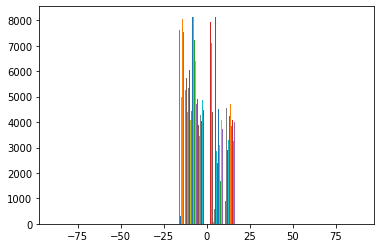

In [15]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

# 스케일링 객체 만들기
scaler = StandardScaler()
# 데이터를 스케일러 하기 좋게 변환
scaler.fit(fact_data_146)
# 스케일링 객체로 수행한 결과를 리턴함
fact_data_scaled = scaler.transform(fact_data_146)

# 데이터 범위 확인
print("스케일링한 데이터 최소값:", fact_data_scaled.min())
print("스케일링한 데이터 최대값:", fact_data_scaled.max())

# 시각화
plt.hist(fact_data_scaled)
# 중앙에만 데이터가 분포되어 있음. 다른 스케일링 기법을 사용하는 것이 적절함

#### MinMaxScaler
    * 모든 feature 값이 0~1사이에 있도록 함
    * (x - min) / (max - min)
        * x: 데이터, min: 최솟값, max: 최댓값
    * 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있음

스케일링한 데이터 최소값: 0.0
스케일링한 데이터 최대값: 1.0000000000000002


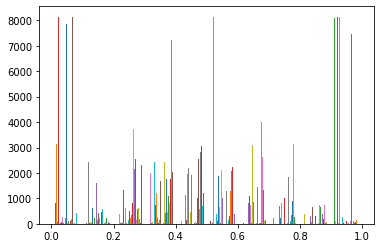

In [16]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(fact_data_146)
fact_data_scaled = scaler.transform(fact_data_146)


# 데이터 범위 확인
print("스케일링한 데이터 최소값:", fact_data_scaled.min())
print("스케일링한 데이터 최대값:", fact_data_scaled.max())

# 시각화
plt.hist(fact_data_scaled)
plt.show()

# 값이 0과 1 사이에 고루 분포하여 비교하기 쉬운 MinMax 스케일링 선택

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


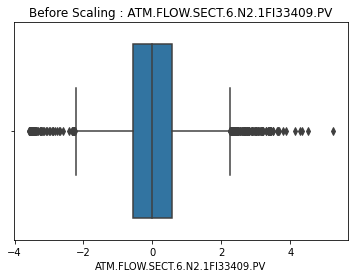

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


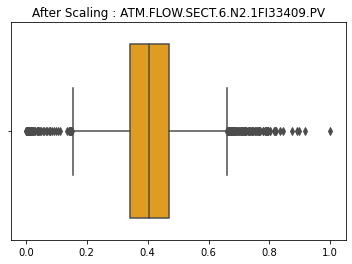

In [17]:
# 스케일링 전, 후 데이터 분포 비교
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(fact_data_146.iloc[:,95])
plt.title("Before Scaling : " + fact_data_146.iloc[:,95].name)
plt.show()
sns.boxplot(fact_data_scaled[:,95], color = 'orange')
plt.title("After Scaling : " + fact_data_146.iloc[:,95].name)

plt.show()

### PCA 수행
* 참고 링크 : https://excelsior-cjh.tistory.com/167

In [18]:
# PCA 수행
from sklearn.decomposition import PCA

# 피처개수 146개만큼 주성분을 뽑아보자
pca = PCA(n_components=146)

# 스케일링한 값을 넣고 fit() 과 transform()을 호출해 PCA 변환 데이터 리턴
pca.fit(fact_data_scaled)
fact_data_pca = pca.transform(fact_data_scaled)

# PCA 수행 후 데이터 확인
print("데이터 구조", fact_data_pca.shape)

# 설명변수
## 각 주성분이 전체 데이터 집합을 얼마나 잘 설명하는지 나타내는 값
print("- 각 주성분의 설명변수 :", pca.explained_variance_[:4])
# 설명변수 비율
## 전체 주성분의 설명변수 비율 합은 1(100%)
print("- 각 주성분의 설명변수 비율 :", pca.explained_variance_ratio_[:4])
# 주성분 행렬
print('- singular value :', pca.singular_values_[:4])

데이터 구조 (8145, 146)
- 각 주성분의 설명변수 : [0.71985174 0.35831365 0.28276449 0.16948414]
- 각 주성분의 설명변수 비율 : [0.2556693  0.12726204 0.10042929 0.06019558]
- singular value : [76.566785   54.01950008 47.98785236 37.15210376]


In [19]:
# PCA 수행 결과를 데이터프레임으로 만들어서 확인

# 컬럼이름 붙이기
pca_columns_name = [f"pca{num+1}" for num in range(fact_data_146.shape[1])]
# 데이터프레임 만들기
pca_df = pd.DataFrame(fact_data_pca, columns = pca_columns_name, index=fact_data_146.index)
pca_df.info()
pca_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 146 entries, pca1 to pca146
dtypes: float64(146)
memory usage: 9.1+ MB


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,...,pca107,pca108,pca109,pca110,pca111,pca112,pca113,pca114,pca115,pca116,pca117,pca118,pca119,pca120,pca121,pca122,pca123,pca124,pca125,pca126,pca127,pca128,pca129,pca130,pca131,pca132,pca133,pca134,pca135,pca136,pca137,pca138,pca139,pca140,pca141,pca142,pca143,pca144,pca145,pca146
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,1.917686,0.034701,1.074632,-1.098696,0.239249,-0.038853,0.063102,-0.054615,0.183078,-0.444736,0.571278,-0.484651,-0.376521,0.708671,0.011844,0.059581,0.474969,0.258691,0.100570,-0.054160,0.071503,-0.191445,-0.133890,-0.008906,0.385236,-0.048660,-0.000565,0.114355,0.225210,-0.202785,0.413593,0.399861,-0.013938,0.005668,-0.089786,0.015714,0.050465,-0.280216,-0.168110,0.073579,...,0.043764,-0.060851,-0.009090,0.056480,0.023994,0.011606,-0.008219,0.017447,-0.035295,-0.032902,0.014860,-0.026567,0.000796,0.039795,-0.011428,0.030279,-0.011702,0.000317,-0.000517,0.034062,0.013098,-0.007691,-0.015841,0.001721,-0.002455,-0.009139,0.000560,-0.003558,0.002767,-0.001632,-0.003513,-0.060332,0.000473,0.001536,0.009695,0.005029,-0.003204,0.005807,0.000043,-0.000053
2016-01-01 08,1.873577,0.023578,1.033960,-1.114624,0.236641,-0.082440,0.076214,-0.070398,0.133788,-0.470866,0.568749,-0.518830,-0.315820,0.646503,-0.009128,0.091090,0.485849,0.287933,0.037209,-0.064214,0.058784,-0.154887,-0.112596,-0.058794,0.294235,-0.077846,-0.047706,0.104400,0.190319,-0.038307,0.289653,0.335202,-0.048067,0.022498,-0.095266,0.046375,0.090875,-0.196736,-0.121504,-0.063730,...,0.014046,0.019699,0.020542,-0.017040,-0.014460,0.019008,-0.000505,0.008083,-0.035081,-0.034627,0.044391,-0.016766,0.005650,0.002625,0.016467,0.006318,-0.000981,-0.002236,0.003859,0.007816,0.012275,-0.005543,-0.008298,0.000845,0.000711,0.001207,-0.001095,0.001600,0.000048,0.000873,-0.004037,0.007115,-0.002042,-0.007480,0.006445,0.009470,-0.002098,0.004483,-0.000333,-0.003800
2016-01-01 09,1.930027,0.005639,1.092750,-1.159063,0.219772,-0.068032,0.064610,-0.097405,0.201265,-0.434027,0.596941,-0.545472,-0.305367,0.606743,0.040142,0.053799,0.389235,0.257648,0.127493,0.013975,0.020643,-0.146355,-0.159841,-0.073630,0.368593,-0.009929,-0.082289,0.144092,0.178793,0.017155,0.238576,0.437717,-0.010566,0.062677,-0.066373,0.254799,0.069974,-0.069917,-0.123252,0.059678,...,0.099988,0.039947,-0.027258,-0.031532,-0.055563,0.050614,-0.013372,0.041771,-0.015184,-0.043917,0.014197,0.012075,0.008269,-0.003720,0.009304,0.021010,-0.007929,-0.001632,0.003866,0.003899,0.021011,-0.013324,-0.012249,0.001192,-0.002837,0.002593,-0.002314,0.001811,0.000661,0.000067,-0.005855,0.003408,-0.002836,-0.004716,0.003766,0.007087,-0.002214,0.002525,-0.000182,-0.000246
2016-01-01 10,1.940595,0.021564,1.081243,-1.140183,0.243633,-0.065563,0.088831,-0.066134,0.183097,-0.485478,0.531043,-0.574331,-0.317647,0.655486,0.012740,0.098029,0.453114,0.284585,0.081385,-0.069629,0.081959,-0.157548,-0.093025,-0.025244,0.344024,-0.095950,-0.030649,0.163418,0.194255,-0.001693,0.286676,0.364503,-0.061568,0.036839,-0.105176,0.042022,0.032280,-0.191863,-0.147121,-0.088740,...,-0.000463,0.015020,0.010079,-0.003481,-0.011421,0.012550,-0.006829,0.018054,-0.042063,-0.022874,0.044447,-0.014531,0.013460,-0.007295,0.011337,0.028943,0.007682,-0.005383,0.001440,0.003702,0.009006,-0.002898,-0.009185,0.000141,0.001530,0.005874,0.001465,0.001984,-0.001920,-0.004856,-0.003367,-0.002286,-0.003342,-0.004027,0.004549,0.011038,-0.002425,0.004567,0.000294,-0.000602
2016-01-01 11,2.024965,0.010032,1.130196,-1.155367,0.269952,-0.038374,0.126958,-0.073194,0.233497,-0.412951,0.527891,-0.627785,-0.229127,0.578650,0.055895,-0.017158,0.365445,0.291524,0.128094,0.024802,-0.003801,-0.195332,-0.131480,0.032334,0.326158,-0.017112,-0.027417,0.215237,0.157423,-0.0

#### 적당한 n_components 개수 정하기
* 방법1
    - 설명변수가 급감하는 때의 주성분 인덱스를 찾음
    - 이 경우 최소한의 주성분 개수로 전체 데이터의 경향을 설명할 수 있음
* 방법2
    - 설명변수 비율의 누적합이 0.95일 때의 주성분 개수로 선택할 수 있음
    - 이 경우 전체 데이터의 95%를 설명하기 위한 주성분 개수를 구하는 것과 같음

Text(0, 0.5, 'explained_variance_')

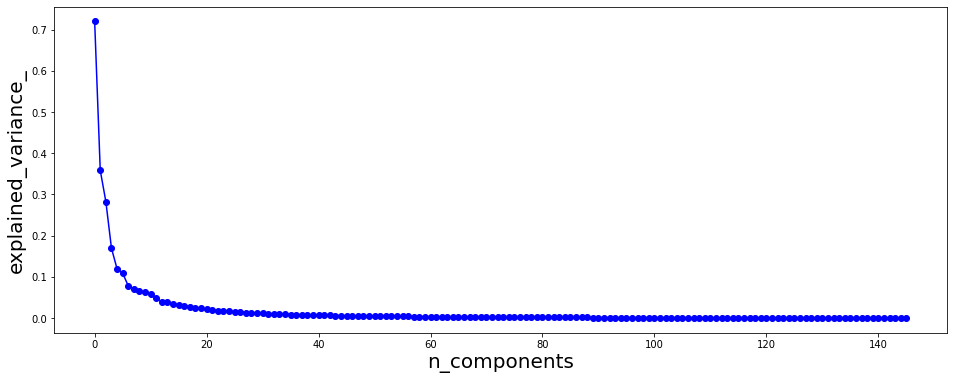

In [20]:
# 방법1 이용함
# Scree Plot 그리기
# x축 : n_components 수
# y축 : 설명변수
plt.figure(figsize=(16, 6))
plt.plot(pca.explained_variance_, marker='o', c='blue')
plt.xlabel("n_components", fontsize=20)
plt.ylabel("explained_variance_", fontsize=20)
# Elbow(그래프가 급격히 꺾이는 지점) 확인
# n_components = 5, 주성분 5개로 전체 데이터를 설명할 수 있을 것으로 보임

In [21]:
# 데이터프레임으로 보기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_, '기여율':pca.explained_variance_ratio_},
                      index=pca_columns_name)
result[:10]

,설명가능한 분산 비율(고윳값),기여율
pca1,0.719852,0.255669
pca2,0.358314,0.127262
pca3,0.282764,0.100429
pca4,0.169484,0.060196
pca5,0.119400,0.042407
pca6,0.108608,0.038574
pca7,0.078175,0.027765
pca8,0.071123,0.025261
pca9,0.064336,0.022850
pca10,0.061912,0.021989


## 데이터 레이블을 이용하여 불량품/양품 구분하기
1. 레이블 데이터 탐색
2. 이상치 확인
    - IQR = Q3 - Q1
    - 제3분위수·제1분위수보다 1.5*IQR 만큼 바깥에 있으면 이상치로 판단
    - Q1 - 1.5IQR보다 작은값
    - Q3 + 1.5IQR보다 큰 값
3. 불량품/양품 분류 기준 잡기


In [22]:
# 레이블 데이터 확인
origin_data.iloc[:, -4:]

,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,
2016-01-01 07,0.025,0.063,0.108,0.041
2016-01-01 08,0.000,0.022,0.133,0.000
2016-01-01 09,0.016,0.063,0.000,0.000
2016-01-01 10,0.000,0.103,0.000,0.000
2016-01-01 11,0.000,0.000,0.000,0.000
...,...,...,...,...
2016-12-31 19,0.000,0.031,0.144,0.000
2016-12-31 20,0.010,0.021,0.121,0.009
2016-12-31 21,0.017,0.009,0.100,0.027


■ L.Vac의 분포


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


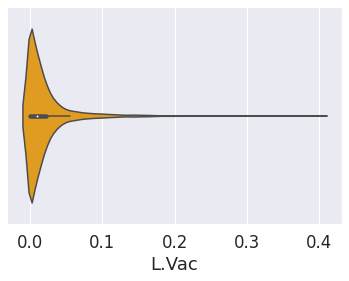

count    8145.000000
mean        0.019174
std         0.031836
min         0.000000
25%         0.000000
50%         0.010000
75%         0.022000
max         0.400000
Name: L.Vac, dtype: float64
Q1: 0.0
Q2: 0.01
Q3: 0.022000000000000002
90%: 0.05


In [23]:
# L.Vac의 데이터 확인
df_LVac = origin_data.iloc[:, -3]

print("■ L.Vac의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LVac, color='orange')
plt.show()
print(df_LVac.describe())

print("Q1:", df_LVac.quantile(0.25))
print("Q2:", df_LVac.quantile(0.50))
print("Q3:", df_LVac.quantile(0.75))
print("90%:", df_LVac.quantile(0.9))

■ L.RD의 분포


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


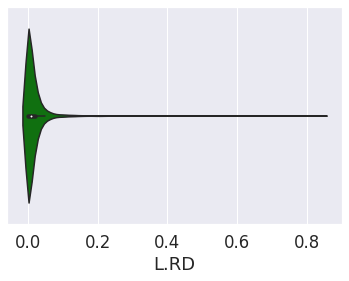

count    8145.000000
mean        0.018049
std         0.045042
min         0.000000
25%         0.000000
50%         0.009000
75%         0.020000
max         0.841000
Name: L.RD, dtype: float64
제1분위수: 0.0
제2분위수: 0.009000000000000001
제3분위수: 0.02
90%에 위치한 값: 0.04
IQR: 0.02
under_bound: [0]
upper_bound: 0.05


In [24]:
# L.RD의 데이터 확인
#plt.boxplot(origin_data.iloc[:, -4], vert=False)

df_LRD = origin_data.iloc[:, -4]

print("■ L.RD의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LRD, color='green')
plt.show()
print(df_LRD.describe())

# 이상치 구하기
# 확인
print("제1분위수:", df_LRD.quantile(0.25))
print("제2분위수:", df_LRD.quantile(0.50))
print("제3분위수:", df_LRD.quantile(0.75))
print("90%에 위치한 값:", df_LRD.quantile(0.9))

Q1 = df_LRD.quantile(0.25)
Q3 = df_LRD.quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

arr=[Q1-1.5*IQR]
under_bound = [0 if x<0 else x for x in arr]
upper_bound = Q3 + 1.5*IQR
print("under_bound:", under_bound)
print("upper_bound:", upper_bound)

# 불량품/양품 기준
# 'L.RD' 0.05 이상이면 불량품, 미만이면 양품으로 결정함

In [25]:
# 레이블 데이터 확인
origin_data.iloc[:, -4:-2]

,L.RD,L.Vac
dat...date.name.,,
2016-01-01 07,0.025,0.063
2016-01-01 08,0.000,0.022
2016-01-01 09,0.016,0.063
2016-01-01 10,0.000,0.103
2016-01-01 11,0.000,0.000
...,...,...
2016-12-31 19,0.000,0.031
2016-12-31 20,0.010,0.021
2016-12-31 21,0.017,0.009


### 불량품/양품 컬럼 만들기

In [26]:
# 타겟 데이터
# 'L.RD' 0.05 이상이면 불량품, 미만이면 양품으로 결정함
df_LRD = origin_data.iloc[:, -4]
df_LRD[df_LRD.values >= 0.05] = 1
df_LRD[df_LRD.values != 1] = 0

print(df_LRD.unique())
print("■ 레이블 개수\n", df_LRD.value_counts())

[0. 1.]
■ 레이블 개수
 0.0    7556
1.0     589
Name: L.RD, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 레이블 데이터 합치기 ■ fact_data_LRD
* fact_data_LRD : 레이블을 L.RD로 쓰고 한글컬럼은 제외한 데이터
---
* 데이터 프레임 합치기 : pd.merge와 pd.concat의 차이
* 참고링크 : https://yganalyst.github.io/data_handling/Pd_12/#1-1-pdconcat%EC%9D%98-%EC%98%B5%EC%85%98

In [27]:
# 레이블 없는 데이터에 레이블 시리즈 합치기
fact_data_LRD = pd.concat([fact_data_146, df_LRD], axis=1)
print(fact_data_LRD.shape)

# 만약 여기서 행 개수가 8145개를 넘으면 concat할 때 두 데이터프레임의 인덱스가 달라서 달리 합쳐진 것일 수 있음
# df_origin 불러올 때 인덱스 설정을 동일하게 해주자
# 혹은 fact_data_152['레이블 이름']으로 추가할 수 있음

(8145, 147)


## PCA로 산포도 그리기
* pca 주성분 2개로 산포도 그리기
* 원본 데이터 중 중요도가 높은 피처 2개로 산포도 그리기

In [28]:
# PCA n_components=2로 수행
pca = PCA(n_components=2)
pca.fit(fact_data_scaled)
fact_data_pca = pca.transform(fact_data_scaled)

In [29]:
# PCA 수행 결과를 데이터프레임으로 만들어서 확인
# 컬럼이름 붙이기
pca_columns_name = ['pca_1','pca_2']
# 데이터프레임 만들기
pca_df = pd.DataFrame(fact_data_pca, columns = pca_columns_name, index=fact_data_146.index)
pca_df = pd.concat([pca_df, df_LRD], axis=1)
pca_df.info()
pca_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pca_1   8145 non-null   float64
 1   pca_2   8145 non-null   float64
 2   L.RD    8145 non-null   float64
dtypes: float64(3)
memory usage: 254.5+ KB


,pca_1,pca_2,L.RD
dat...date.name.,,,
2016-01-01 07,1.917686,0.034701,0.0
2016-01-01 08,1.873577,0.023578,0.0
2016-01-01 09,1.930027,0.005639,0.0
2016-01-01 10,1.940595,0.021564,0.0
2016-01-01 11,2.024965,0.010032,0.0


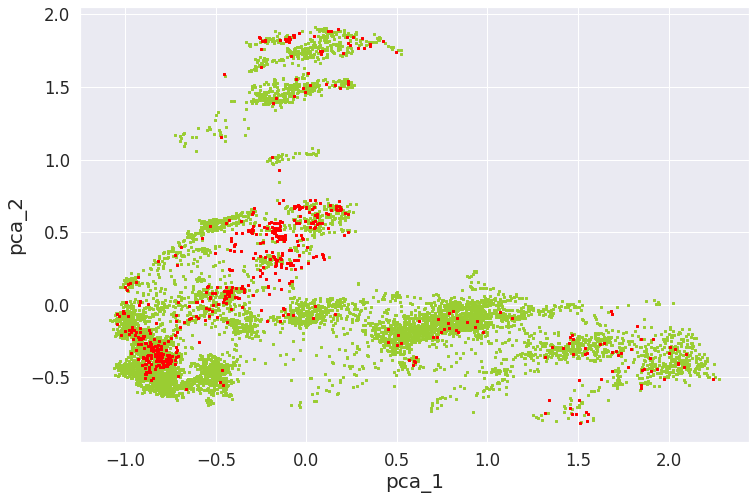

In [30]:
# 산포도 그리기
plt.figure(figsize=(12, 8))
plt.xlabel('pca_1', fontsize=20)
plt.ylabel('pca_2', fontsize=20)

# 타겟 데이터의 값에 따라 색을 다르게 칠함
colors=['yellowgreen', 'red']
for i , color in enumerate(colors):
    # pca_1 데이터
    x_axis_data = pca_df[pca_df.iloc[:, -1]==i].iloc[:,0]
    # pca_2 데이터
    y_axis_data = pca_df[pca_df.iloc[:, -1]==i].iloc[:,1]
    plt.scatter(x_axis_data, y_axis_data , c=color,  marker='s', s=5)

# 주성분이 타겟데이터를 잘 설명하지 못함
# 타겟데이터가 문제인지, 컬럼 제거 과정에서 중요 피처가 삭제된 것인지 확인

---
## 분류 모델

In [31]:
from sklearn.model_selection import train_test_split

# 피처/레이블 데이터 나누기
X = fact_data_LRD.iloc[:, :-1]
y = fact_data_LRD.iloc[:, -1]

# 훈련/테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6108, 146)
(2037, 146)
(6108,)
(2037,)


In [32]:
# 의사결정나무 모델 사용
from sklearn.tree import DecisionTreeClassifier
# 모델 만들기
model_classifier = DecisionTreeClassifier()
# 훈련
model_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
# 예측
pred = model_classifier.predict(X_test)
print("예측값", pred[90:110])
print("레이블", y_test.values[90:110])

예측값 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
레이블 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 평가지표
- 어떤 평가지표를 사용할지 고민해야 함
    - 정확도, 정밀도, 재현율, F1 Score
- 이 데이터에서는 극소수의 불량품을 판정하지 못하는 것이 치명적임
    - 따라서 정확도는 적절치 않음
    - FP가 높고, FN이 낮은지 중점적으로 살펴야 함
    - F1 Score가 적절할 것 같음

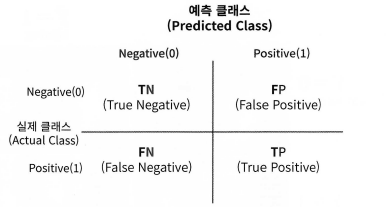

In [34]:
# 평가지표
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1.0 불량, 0.0 양품
print("- 레이블 개수\n", df_LRD.value_counts())
print()
print("- confusion_matrix :\n", confusion_matrix(pred, y_test))
print("- accuracy_score :", accuracy_score(pred, y_test).round(3))
print("- precision_score :", precision_score(pred, y_test))
print("- recall_score :", recall_score(pred, y_test))
print("- f1_score :", f1_score(pred, y_test).round(3))
print("- roc_auc_score :", roc_auc_score(pred, y_test).round(3))

- 레이블 개수
 0.0    7556
1.0     589
Name: L.RD, dtype: int64

- confusion_matrix :
 [[1803   84]
 [  89   61]]
- accuracy_score : 0.915
- precision_score : 0.4206896551724138
- recall_score : 0.4066666666666667
- f1_score : 0.414
- roc_auc_score : 0.681
